## Lab 04 - Object Recognition

Student: Gaia Volpi, ID: 2107759

In [2]:
import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-401-g46824cc9 Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48677MiB)


Setup complete ✅ (128 CPUs, 503.5 GB RAM, 905.0/915.3 GB disk)


## 1. Road signs

### 1.1 Train the model
YOLOv5 model is trained on some custom dataset of road signs from https://www.kaggle.com/datasets/valentynsichkar/yolo-v5-format-of-the-traffic-signs-dataset.

Structure: 
- Training set: 678 images
- Test set: 74 images
- Validation set: 148 images

Classes:
- Prohibitory
- Danger
- Mandatory
- Other

In [30]:
!python3 train.py --img 640 --batch 32 --epochs 50 --data rs.yaml --weights yolov5s.pt --cache --name road_signs_train

train: weights=yolov5s.pt, cfg=, data=rs.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=road_signs_train, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-401-g46824cc9 Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48677MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, c

### 1.2 Detect 

Let's now use the trained weights to detect road signs in the desidered images, both in the easier and more challenging ones.

In [44]:
!python3 detect.py --source data/images/easy/road_signs/ --weights runs/train/road_signs_train/weights/best.pt --conf 0.25 --name road_signs_easy --save-txt

detect: weights=['runs/train/road_signs_train/weights/best.pt'], source=data/images/easy/road_signs/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=road_signs_easy, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-401-g46824cc9 Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48677MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/6 /home/alberto_sinigaglia/gaia/cv/data/images/easy/road_signs/rs1.jpg: 480x640 1 prohibitory, 30.1ms
image 2/6 /home/alberto_sinigaglia/gaia/cv/data/images/easy/road_signs/rs2.jpg: 480x640 1 prohibitory, 4.4ms
image 3/6 /home/alberto_sinigaglia/gaia/cv/data/images/

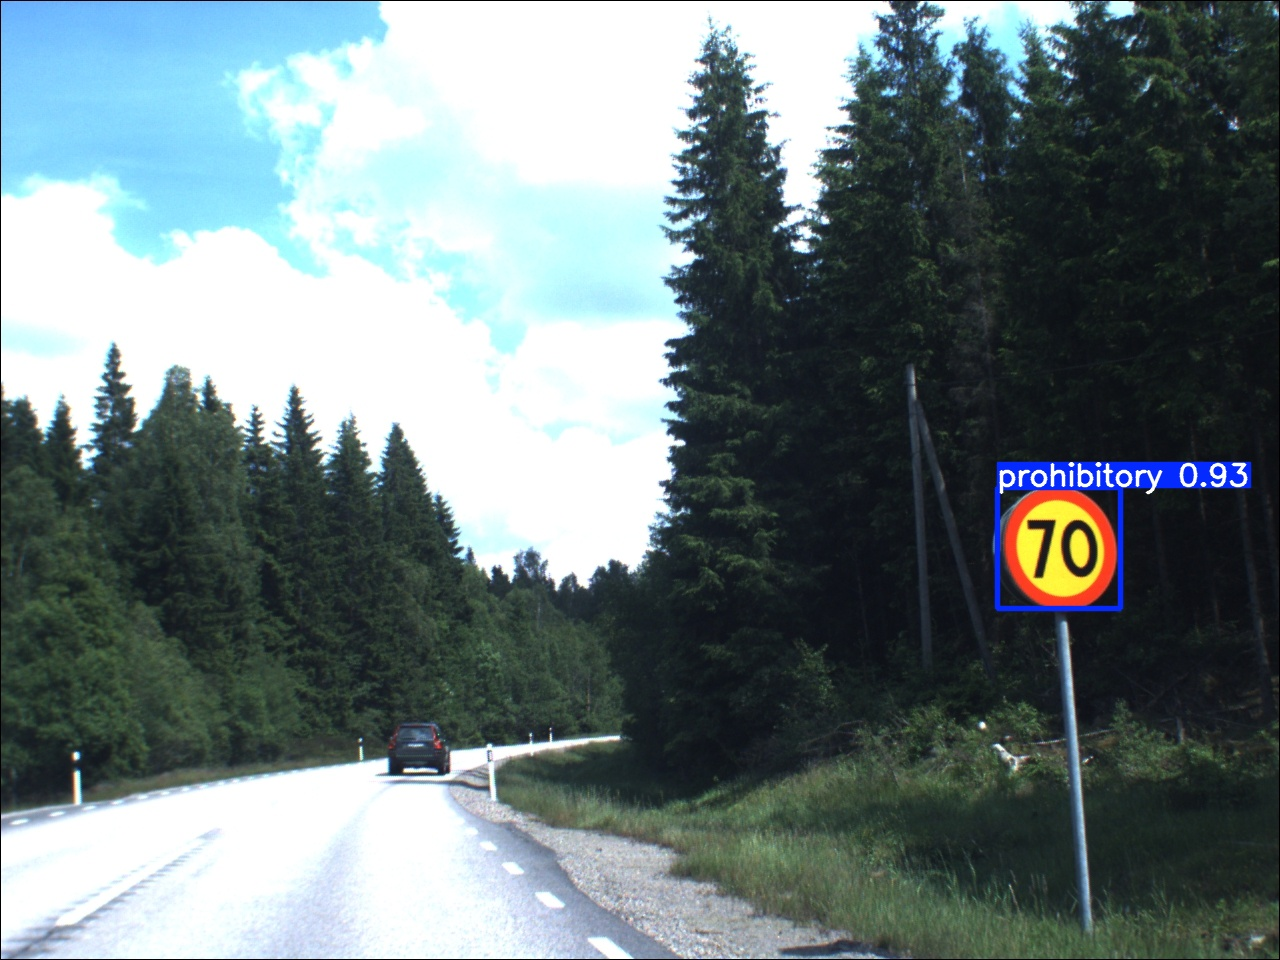

In [4]:
display.Image(filename='runs/detect/road_signs_easy/rs1.jpg', width=600)

In [45]:
!python3 detect.py --source data/images/hard/road_signs/ --weights runs/train/road_signs_train/weights/best.pt --conf 0.25 --name road_signs_hard --save-txt

detect: weights=['runs/train/road_signs_train/weights/best.pt'], source=data/images/hard/road_signs/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=road_signs_hard, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-401-g46824cc9 Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48677MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/4 /home/alberto_sinigaglia/gaia/cv/data/images/hard/road_signs/rs1h.jpg: 480x640 1 prohibitory, 3 others, 30.8ms
image 2/4 /home/alberto_sinigaglia/gaia/cv/data/images/hard/road_signs/rs2h.jpg: 480x640 2 mandatorys, 6.3ms
image 3/4 /home/alberto_sinigaglia/gaia/cv/d

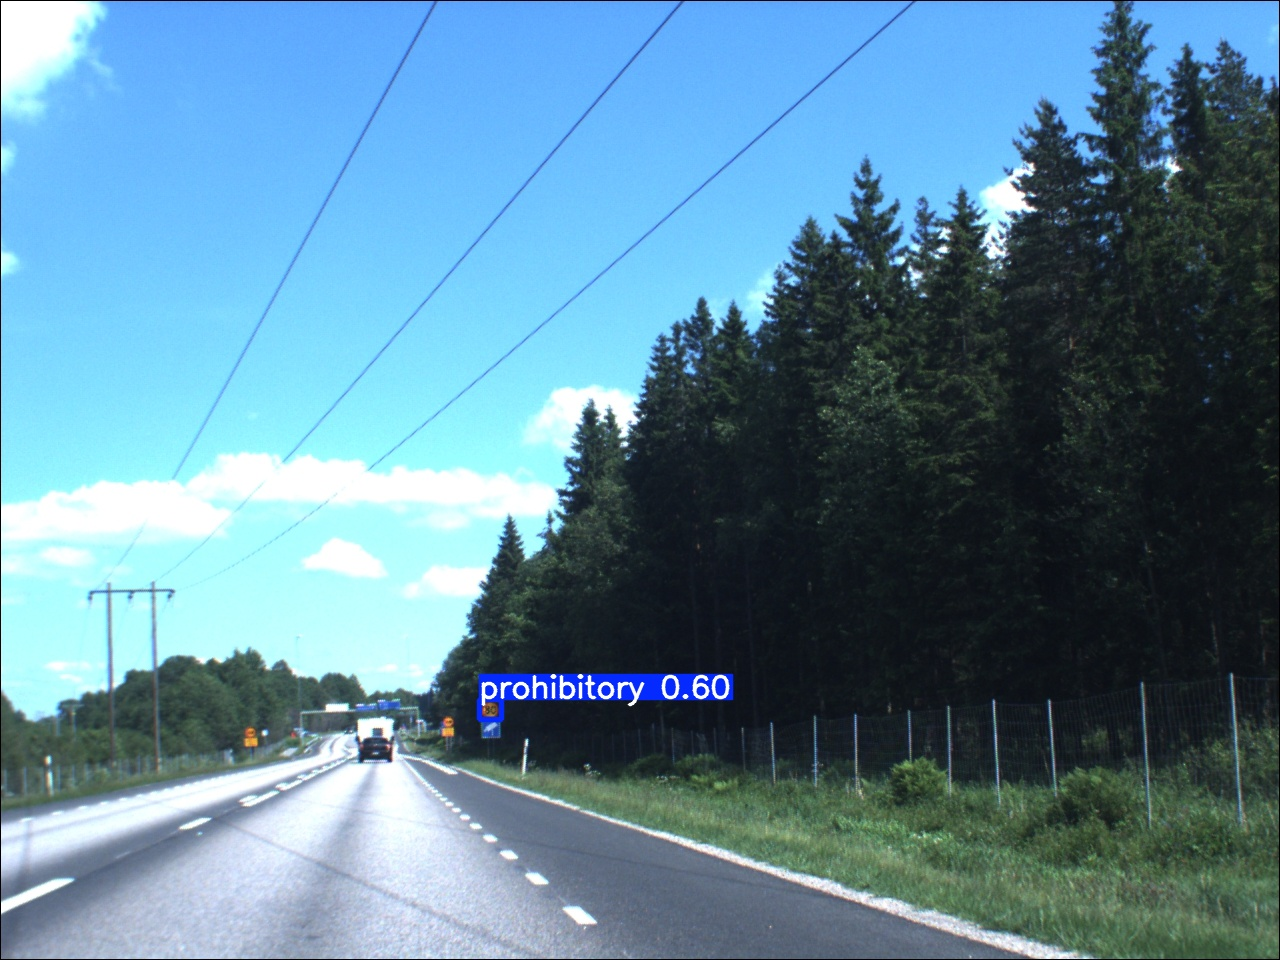

In [43]:
display.Image(filename='runs/detect/road_signs_hard/rs3h.jpg', width=600)

### 1.3 Detect speed limit

#### 1.3.1 OCR
I proceed by cropping the images with detected prohibitory signs using the bounding boxes coordinates. I then feed these images as input to the easyocr algorithm, in order to read the maximum allowed speed value.

In [81]:
import os
import pandas 
import easyocr
import cv2
import matplotlib.pyplot as plt


def ocr(difficulty):
    global_path = f'runs/detect/road_signs_{difficulty}/'
    bb = []
    labels_path = os.path.join(global_path, 'labels')
    for label_file in os.listdir(labels_path):
        base_name = os.path.splitext(label_file)[0]
        with open(os.path.join(labels_path, label_file), 'r') as file:
            for line in file:
                line_split = line.strip().split()
                if line_split[0] == '0':
                    x_center, y_center, width, height = line_split[1:]
                    bb.append([base_name, x_center, y_center, width, height])

    cropped_images=[]
    titles =[]

    for row in bb:
        img_name = row[0] + '.jpg'
        x_center = float(row[1])
        y_center = float(row[2])
        width = float(row[3])
        height = float(row[4])

        img = cv2.imread(f'data/images/{difficulty}/road_signs/{img_name}')
        img = cv2.bilateralFilter(img,9,50,50)

        left = int((x_center - width / 2) * img.shape[1])
        upper = int((y_center - height / 2) * img.shape[0])
        right = int((x_center + width / 2) * img.shape[1])
        lower = int((y_center + height / 2) * img.shape[0])
        cropped_img = img[upper:lower, left:right]
        cropped_images.append(cropped_img)
 
    reader = easyocr.Reader(['en'])

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, cropped_images)):

        result = reader.readtext(img, allowlist='0123456789', detail=0)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        if result:
            title = f'Detected maximum speed: {result[0]}'
        else:
            title = 'No detected maximum speed'
        ax.set_title(title)

    for ax in axes[len(cropped_images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


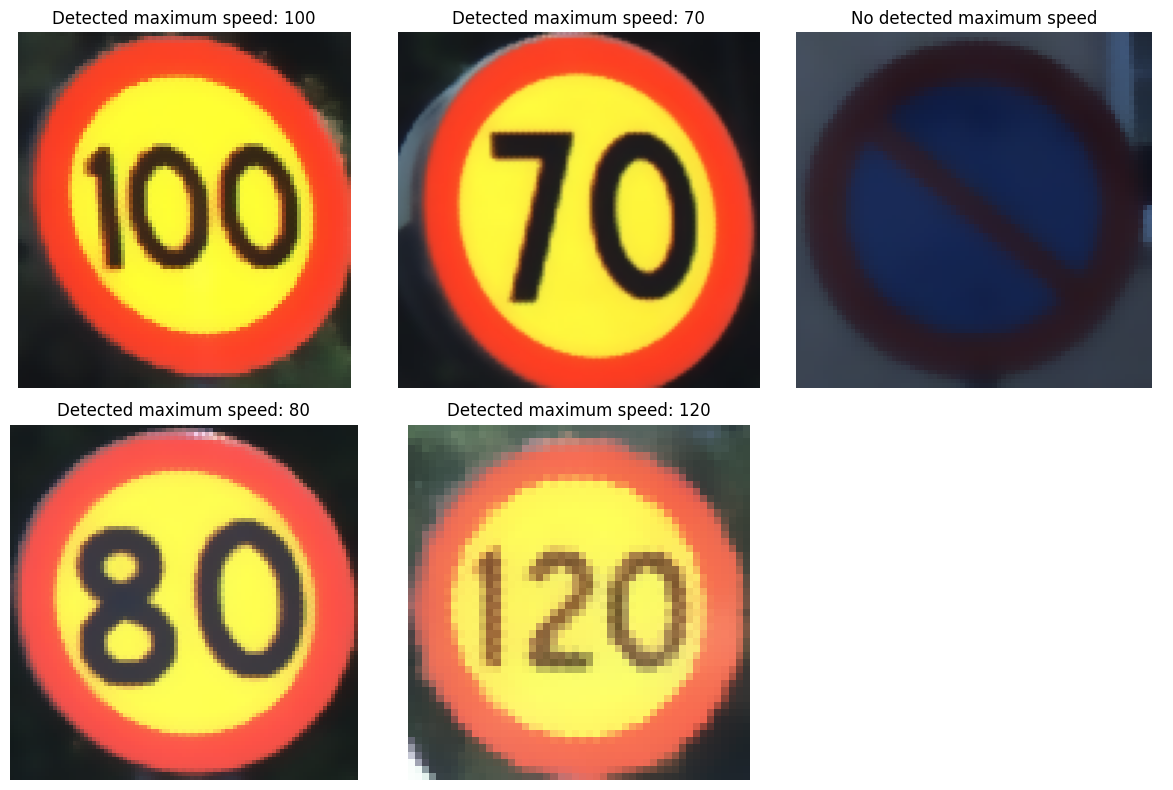

In [82]:
ocr('easy')

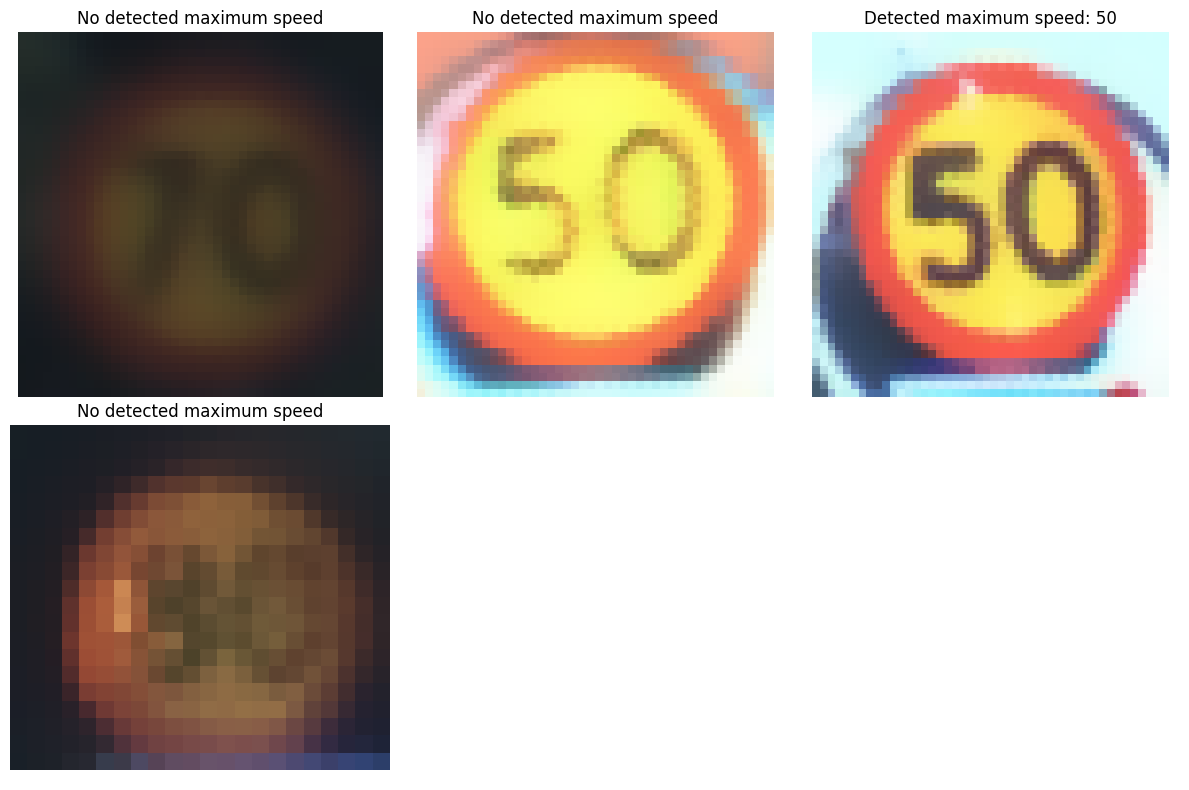

In [83]:
ocr('hard')

#### 1.3.2 yolov5

I try to read the maximum speed value by using yolov5 classifier trained on the dataset obtained at https://www.kaggle.com/datasets/pkdarabi/cardetection?resource=download.

Structure:
- Training set: 3530 images
- Test set: 801 images
- Valid set: 638 images

Labels:
- Green Light
- Red Light
- Speed Limit 10
- Speed Limit 100
- Speed Limit 110
- Speed Limit 120
- Speed Limit 20
- Speed Limit 30
- Speed Limit 40
- Speed Limit 50
- Speed Limit 60
- Speed Limit 70
- Speed Limit 80
- Speed Limit 90
- Stop

In [86]:
!python3 train.py --img 640 --batch 32 --epochs 30 --data sl.yaml --weights yolov5s.pt --cache --name speed_limit_train

train: weights=yolov5s.pt, cfg=, data=sl.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=speed_limit_train, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-401-g46824cc9 Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48677MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, 

In [87]:
!python3 detect.py --source data/images/easy/road_signs/ --weights runs/train/speed_limit_train/weights/best.pt --conf 0.25 --name speed_limit_easy --save-txt

detect: weights=['runs/train/speed_limit_train/weights/best.pt'], source=data/images/easy/road_signs/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=speed_limit_easy, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-401-g46824cc9 Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48677MiB)

Fusing layers... 
Model summary: 157 layers, 7050580 parameters, 0 gradients, 15.9 GFLOPs
image 1/6 /home/alberto_sinigaglia/gaia/cv/data/images/easy/road_signs/rs1.jpg: 480x640 1 Speed Limit 70, 30.4ms
image 2/6 /home/alberto_sinigaglia/gaia/cv/data/images/easy/road_signs/rs2.jpg: 480x640 (no detections), 6.2ms
image 3/6 /home/alberto_sinigaglia/gaia/cv/data/

In [88]:
!python3 detect.py --source data/images/hard/road_signs/ --weights runs/train/speed_limit_train/weights/best.pt --conf 0.25 --name speed_limit_hard --save-txt

detect: weights=['runs/train/speed_limit_train/weights/best.pt'], source=data/images/hard/road_signs/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=speed_limit_hard, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-401-g46824cc9 Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48677MiB)

Fusing layers... 
Model summary: 157 layers, 7050580 parameters, 0 gradients, 15.9 GFLOPs
image 1/4 /home/alberto_sinigaglia/gaia/cv/data/images/hard/road_signs/rs1h.jpg: 480x640 1 Speed Limit 50, 29.7ms
image 2/4 /home/alberto_sinigaglia/gaia/cv/data/images/hard/road_signs/rs2h.jpg: 480x640 (no detections), 6.2ms
image 3/4 /home/alberto_sinigaglia/gaia/cv/dat

In [89]:
def classifier_results(difficulty):
    global_path = f'runs/detect/speed_limit_{difficulty}/'
    bb = []
    labels_path = os.path.join(global_path, 'labels')

    speed_mapping = {'2': '10', '3': '100', '4': '110', '5': '120', 
        '6': '20', '7': '30', '8': '40', '9': '50', 
        '10': '60', '11': '70', '12': '80', '13': '90'}
    
    for label_file in os.listdir(labels_path):
        base_name = os.path.splitext(label_file)[0]
        with open(os.path.join(labels_path, label_file), 'r') as file:
            for line in file:
                line_split = line.strip().split()
                if line_split:
                    class_id = line_split[0]
                    speed = speed_mapping.get(class_id, 'Unknown')
                    x_center, y_center, width, height = line_split[1:]
                    bb.append([base_name, x_center, y_center, width, height, speed])

    cropped_images=[]
    titles =[]

    for row in bb:
        img_name = row[0] + '.jpg'
        x_center = float(row[1])
        y_center = float(row[2])
        width = float(row[3])
        height = float(row[4])
        speed = row[5]

        img = cv2.imread(f'data/images/{difficulty}/road_signs/{img_name}')

        left = int((x_center - width / 2) * img.shape[1])
        upper = int((y_center - height / 2) * img.shape[0])
        right = int((x_center + width / 2) * img.shape[1])
        lower = int((y_center + height / 2) * img.shape[0])
        cropped_img = img[upper:lower, left:right]
        cropped_images.append(cropped_img)

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, cropped_images)):

        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        
        title = f'Detected maximum speed: {speed}'
        ax.set_title(title)

    for ax in axes[len(cropped_images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

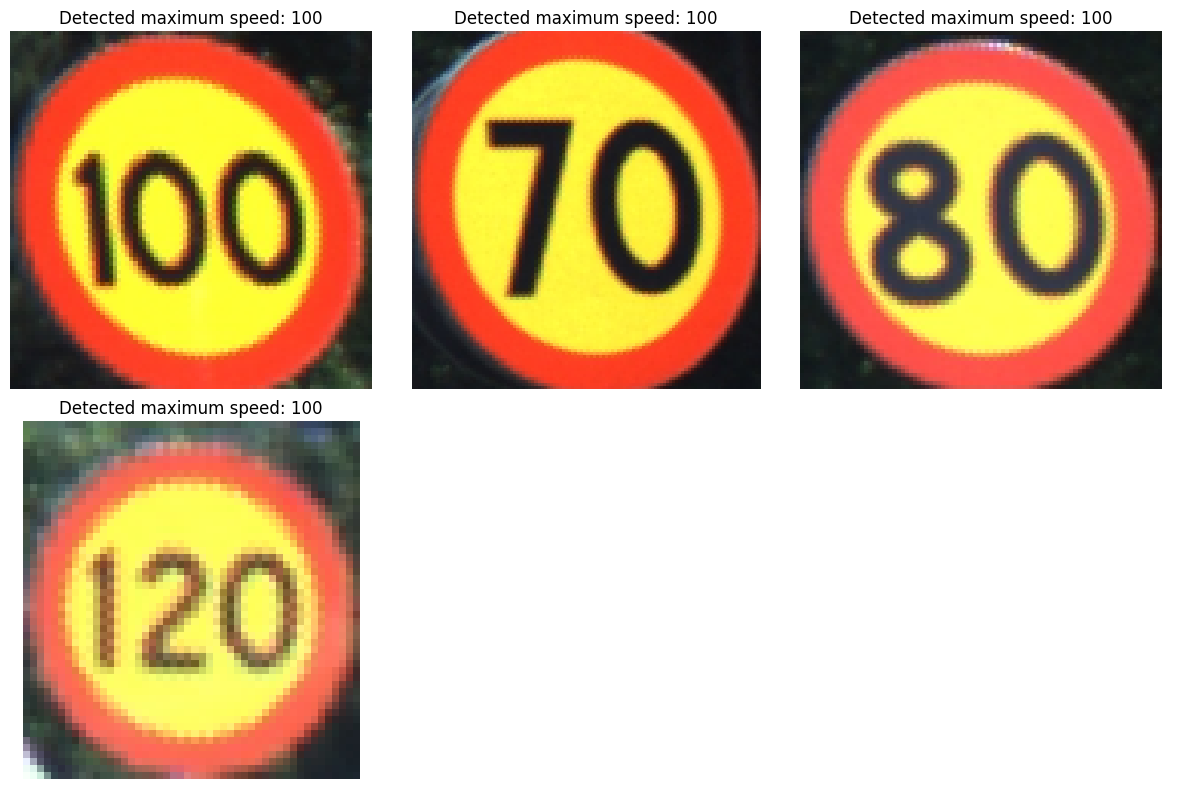

In [90]:
classifier_results('easy')

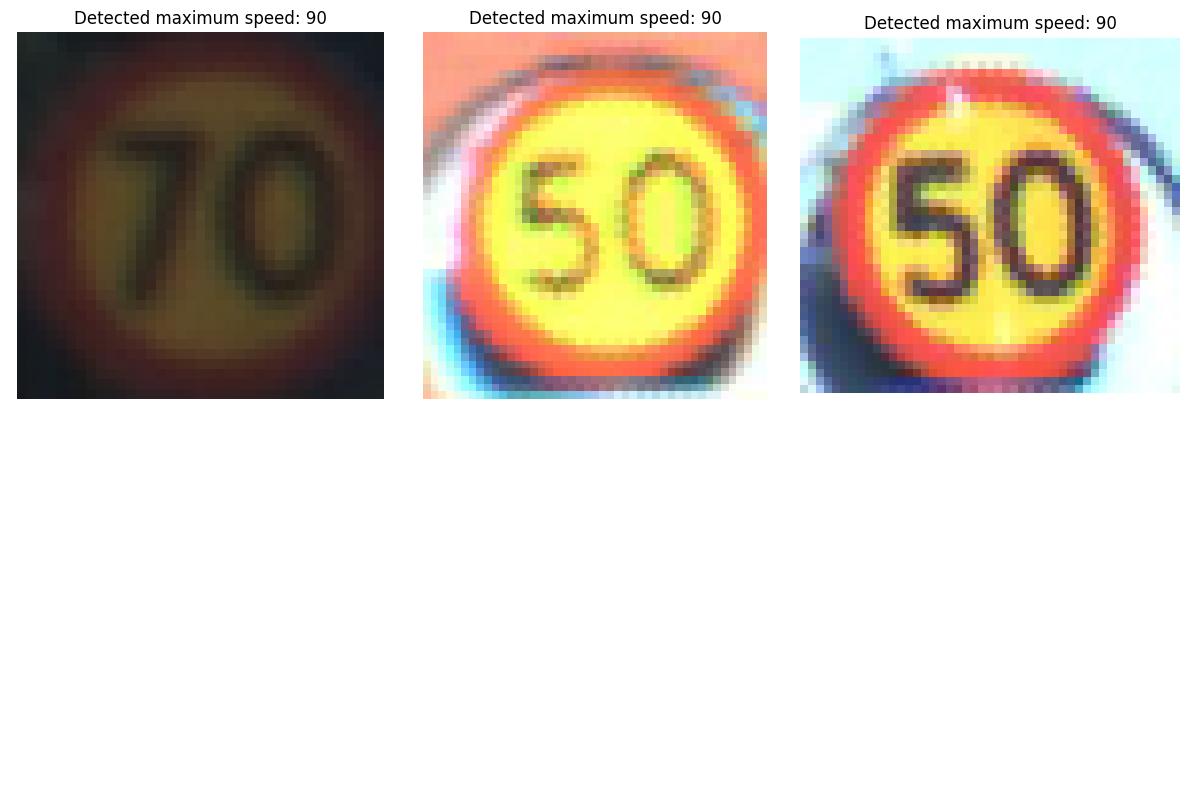

In [91]:
classifier_results('hard')

## 2. Traffic lights
### 2.1 Train the model 

The same model is trained on the traffic lights dataset from https://zenodo.org/records/12706046.

Structure:
- Training set: 4645 images 
- Test set: 4167 images 
- Validation set: 4167 images 

Classes:
- RedLeft
- Red
- RedRight
- GreenLeft
- Green
- GreenRight
- Yellow
- off


In [2]:
!python3 train.py --img 640 --batch 32 --epochs 30 --data tl.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=tl.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-401-g46824cc9 Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48677MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, ob

### 2.2 Detect 

Let's now use the trained weights to detect traffic lights in the desidered images, both the easier and more challenging ones.

In [9]:
!python3 detect.py --source data/images/hard/traffic_lights/ --weights runs/train/traffic_lights_train/weights/best.pt --conf 0.25 --name traffic_lights_hard

detect: weights=['runs/train/traffic_lights_train/weights/best.pt'], source=data/images/hard/traffic_lights/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=traffic_lights_hard, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-401-g46824cc9 Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48677MiB)

Fusing layers... 
Model summary: 157 layers, 7031701 parameters, 0 gradients, 15.8 GFLOPs
image 1/4 /home/alberto_sinigaglia/gaia/cv/data/images/hard/traffic_lights/tl1h.png: 384x640 3 Greens, 29.2ms
image 2/4 /home/alberto_sinigaglia/gaia/cv/data/images/hard/traffic_lights/tl2h.png: 384x640 2 Reds, 4.3ms
image 3/4 /home/alberto_sinigaglia/gaia/cv/d

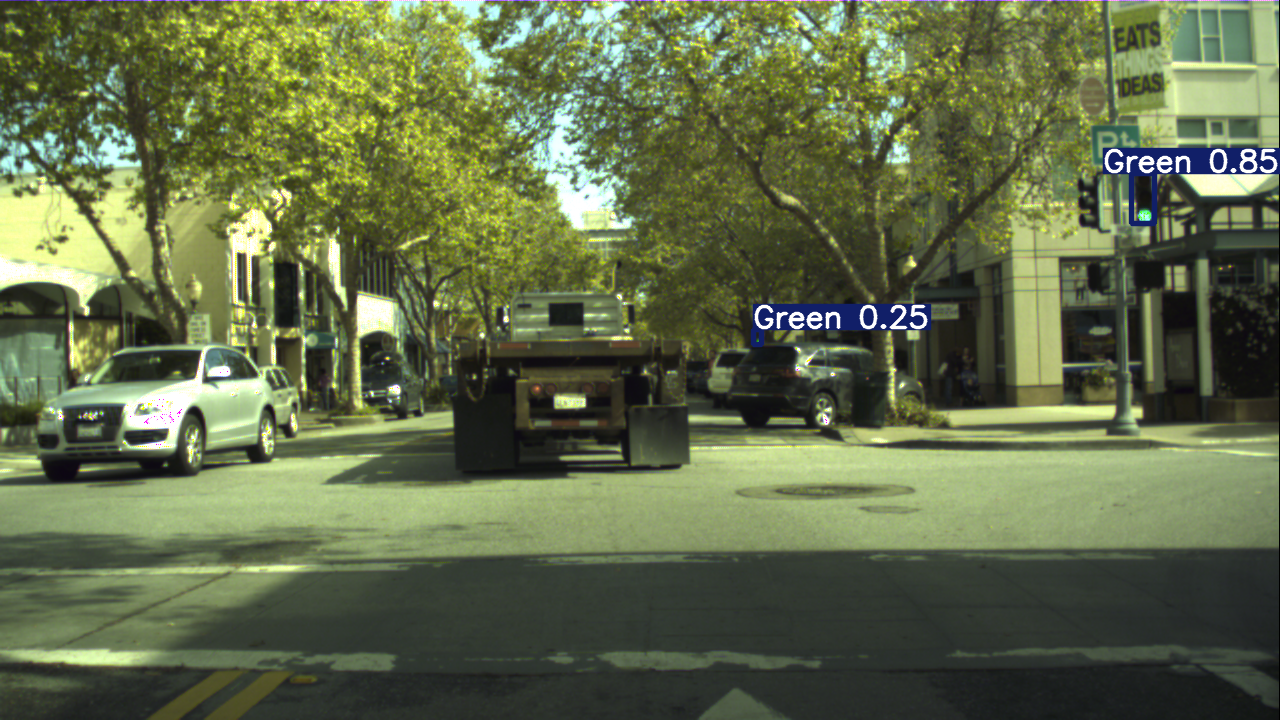

In [44]:
display.Image(filename='runs/detect/traffic_lights_easy/tl1.png', width=600)

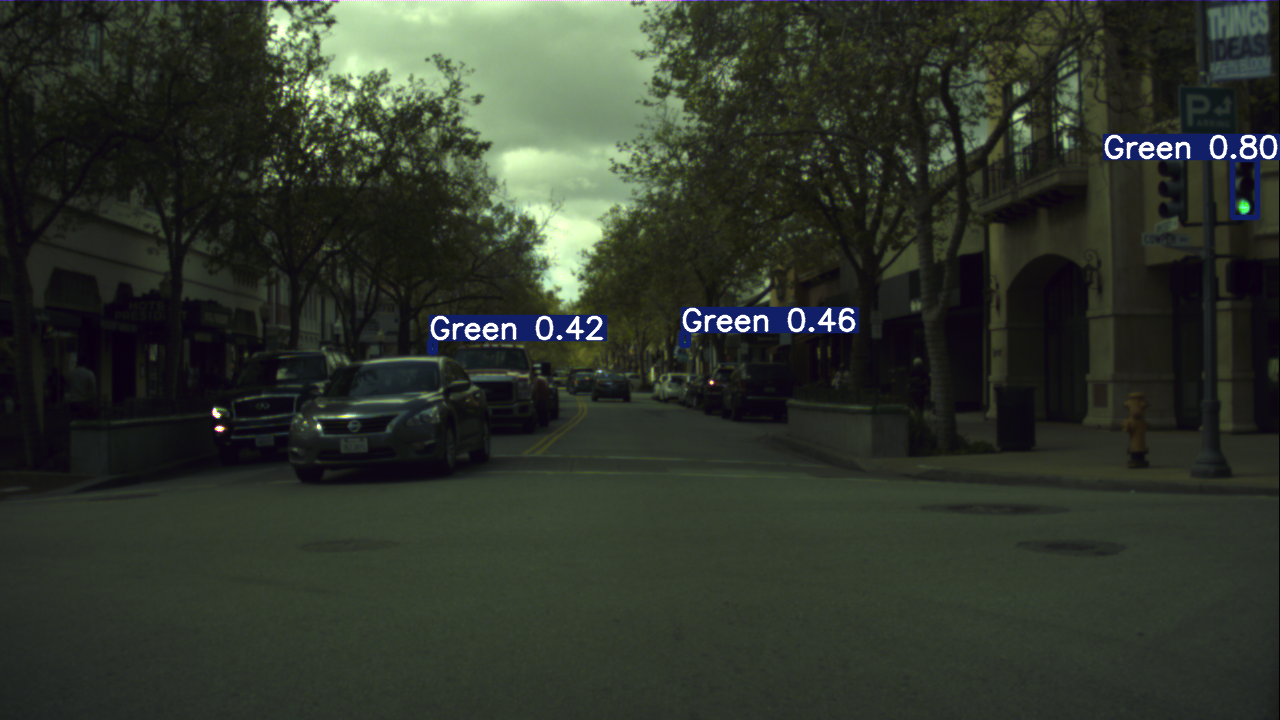

In [45]:
display.Image(filename='runs/detect/traffic_lights_hard/tl1h.png', width=600)